In [11]:
import nibabel as nib
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import cb_tools
from pygam import LinearGAM
from scipy import stats
import matplotlib.gridspec as gridspec
from statsmodels.stats import multitest

In [12]:
results_dir = '/nfs/s2/userhome/liuxingyu/workingdir/cerebellum_grad_dev_v2'
atlas_dir = os.path.join(os.getcwd(), 'atlas')
data_type = 'roi'  # ['roi', 'voxel']

In [13]:
sub_adult = pd.read_csv(os.path.join(results_dir, 'sub_adult'), header=0, dtype={'Sub': np.str})
sub_dev = pd.read_csv(os.path.join(results_dir, 'sub_dev'), header=0, dtype={'Sub': np.str})
num_str_col = 6

# ----------------
# prepare atlas
num_roi = 11
atlas_cb = {'t1wT2wRatio' : 'cb_acapulco_adult', 'fALFF' : 'cb_acapulco_adult-2mm'}
atlas = cb_tools.atlas_load(atlas_cb['t1wT2wRatio'], atlas_dir)
palette_cb = sns.color_palette('plasma', num_roi)

# num_roi = 10
# atlas_cb = {'t1wT2wRatio' : 'cb_anat_fsl', 'fALFF' : 'cb_anat_fsl'}
# atlas = cb_tools.atlas_load(atlas_cb['t1wT2wRatio'], atlas_dir)
# palette_cb = sns.diverging_palette(230,230, l=80, center='dark', n=len(atlas.label_info['lobule'][:20:2]))

# num_roi = 6
# atlas_cb = {'t1wT2wRatio' : 'cb_func_7nw', 'fALFF' : 'cb_func_7nw'}
# atlas = cb_tools.atlas_load(atlas_cb['t1wT2wRatio'], atlas_dir)
# palette_cb = sns.color_palette([tuple(atlas.label_info['color'][i] / 255) for i in [0,1,2,3,5,6]])

# ----------------
# prepare data
data_t1wT2wRatio = pd.read_csv(os.path.join(results_dir, 't1wT2wRatio', f't1wT2wRatio_{atlas_cb["t1wT2wRatio"]}_{data_type}.csv'))
data_falff = pd.read_csv(os.path.join(results_dir, 'fALFF', f'fALFF_{atlas_cb["fALFF"]}_{data_type}.csv'))

In [14]:
if data_type == 'roi': 
    def hemi_merging(x, num_str_col):
        # hemi
        x_l = x[[x.columns[i] for i in range(x.shape[-1]) if x.columns[i].split('_')[-1]=='l']]
        x_l.rename(columns=lambda x: f'{x.split("_")[0]}', inplace=True)
        
        x_r = x[[x.columns[i] for i in range(x.shape[-1]) if x.columns[i].split('_')[-1]=='r']]   
        x_r.rename(columns=lambda x: f'{x.split("_")[0]}', inplace=True)
    
        other_col = [i for i in x.columns if i.split('_')[-1] not in ['l', 'r', 'Vermis']]
        x_merged = pd.concat([pd.concat([x_l,x_r]).mean(level=0), x[other_col]], axis=1)
    
        return x_merged
    
    if atlas_cb['t1wT2wRatio'] != 'cb_func_7nw':
        data_t1wT2wRatio = hemi_merging(data_t1wT2wRatio, num_str_col)
        data_falff = hemi_merging(data_falff, num_str_col)
        lobule_name = atlas.label_info['lobule'][:num_roi*2:2]
    else:
        data_t1wT2wRatio = data_t1wT2wRatio.drop('5-limbic', 1)
        data_falff = data_falff.drop('5-limbic', 1)
        lobule_name = data_t1wT2wRatio.columns[:-num_str_col]
else:
    pass

/nfs/s2/userhome/liuxingyu/.conda/envs/local/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [15]:
def prepare_data(data, sub_adult, sub_dev):
    data = data.astype({'Sub': np.str})
    data_adult = data.merge(sub_adult, on='Sub', how='inner')
    data_dev = data.merge(sub_dev, on='Sub', how='inner')

    # age thr
    data_dev = data_dev[data_dev['Age_in_years'] < 20]
    data_dev = data_dev[data_dev['Age_in_years'] > 8]
    data_dev = data_dev.reset_index(drop=True)

    return data_adult, data_dev

data_t1wT2wRatio_adult, data_t1wT2wRatio_dev = prepare_data(data_t1wT2wRatio, sub_adult, sub_dev)
data_falff_adult, data_falff_dev = prepare_data(data_falff, sub_adult, sub_dev)

In [16]:
def iqr(data, num_str_col, thr=3):
    data.loc[:,data.columns[:-num_str_col]] = cb_tools.thr_IQR(data.loc[:,data.columns[:-num_str_col]].values, times=thr, series=True)
    data = data.dropna()
    return data

if data_type == 'roi': 
    data_t1wT2wRatio_adult = iqr(data_t1wT2wRatio_adult, num_str_col, thr=3)
    data_t1wT2wRatio_dev = iqr(data_t1wT2wRatio_dev, num_str_col, thr=3)
    
    data_falff_adult = iqr(data_falff_adult, num_str_col, thr=3)
    data_falff_dev = iqr(data_falff_dev, num_str_col, thr=3)
else:
    pass

In [17]:
# align data
def inner_sub(dataframe_list):
    sub = set(dataframe_list[0]['Sub'].tolist())
    for dataframe in dataframe_list[1:]:
        sub = sub & set(dataframe['Sub'].tolist())
    return list(sub)
    
# HCP-Adult
sub_adult = inner_sub([data_t1wT2wRatio_adult, data_falff_adult])
sub_adult_df = pd.DataFrame(sub_adult, columns=['Sub'])
data_t1wT2wRatio_adult_coup = data_t1wT2wRatio_adult.merge(sub_adult_df, on='Sub', how='inner')
data_falff_adult_coup = data_falff_adult.merge(sub_adult_df, on='Sub', how='inner')

del data_t1wT2wRatio_adult, data_falff_adult

# HCP-D
sub_dev = inner_sub([data_t1wT2wRatio_dev, data_falff_dev])
sub_dev_df = pd.DataFrame(sub_dev, columns=['Sub'])
data_t1wT2wRatio_dev_coup = data_t1wT2wRatio_dev.merge(sub_dev_df, on='Sub', how='inner')
data_falff_dev_coup = data_falff_dev.merge(sub_dev_df, on='Sub', how='inner')

del data_t1wT2wRatio_dev, data_falff_dev

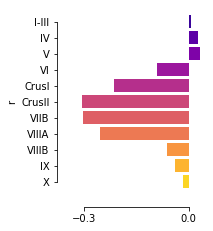

In [18]:
adult_coup = np.asarray([stats.pearsonr(data_t1wT2wRatio_adult_coup[col], data_falff_adult_coup[col])
                       for col in data_t1wT2wRatio_adult_coup.columns[:-num_str_col]])

dev_coup = np.asarray([stats.pearsonr(data_t1wT2wRatio_dev_coup[col], data_falff_dev_coup[col])
                       for col in data_t1wT2wRatio_dev_coup.columns[:-num_str_col]])
# -------------------------------
# isc in adult 

isc_df = pd.DataFrame(np.c_[dev_coup[:,0], data_falff_dev_coup.columns[:-num_str_col]], columns=['coup', 'roi']) 
# plot

_, ax = plt.subplots(figsize=[2.5,3.5])
ax.barh(isc_df['roi'][::-1], isc_df['coup'][::-1], color=palette_cb[::-1])
ax.set_ylabel('r')
ax.set_xlim((-0.35, 0.05))
ax.set_xticks([-0.3, 0])
sns.despine(offset=10, trim=True)

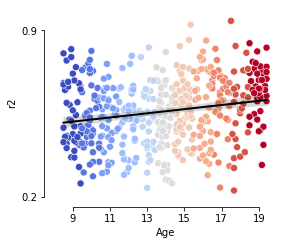

In [19]:
coup = cb_tools.isc(data_t1wT2wRatio_dev_coup.iloc[:,:-num_str_col], data_falff_dev_coup.iloc[:,:-num_str_col])
coup = pd.DataFrame(coup, columns=['coup'])
coup['r2'] = coup['coup']**2
coup = pd.concat((coup, data_t1wT2wRatio_dev_coup.iloc[:,-num_str_col:]), axis=1)
# threshold by 3 IQR

data = copy.deepcopy(coup)
data = iqr(data, num_str_col, thr=1.5)
data.dropna(inplace=True)
data_g = data.groupby(['Age_in_years']).median().loc[:, data.columns[:-num_str_col]]
# plot

x = 'Age'
y = 'r2'
# plot scatter

_, ax = plt.subplots(nrows=1, ncols=1, figsize=[4, 3.5]) 
data['Age'] = data['Age_in_months'] /12
sns.scatterplot(x=x, y=y, hue='Age_in_years', data=data, s=50, palette='coolwarm', ax=ax, legend=False)
sns.regplot(x=x, y=y, data=data, scatter=False, ax=ax, color='k', line_kws={'lw':2})
ax.set_xlim([8,20])
ax.set_xticks(np.arange(9, 20, 2))
ax.set_ylim([0.2, 1])
ax.set_yticks([0.2, 0.9])
sns.despine(offset=10, trim=True)